# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

In [522]:
#!pip install holidays
#!pip install shap

import pandas as pd 
from pandas_profiling import ProfileReport
import plotly.express as px
import numpy as np
import datetime as dt
import holidays

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

pd.set_option('display.max_columns', None)

In [718]:
data = pd.read_csv('bike-sharing_hourly.csv')
data

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.2879  0.81     0.0000       3   
1               0           1  0.22  0.2727  0.80     0.0000       8   
2               0           1  0.22  0.2727  0.80     0.0000       5   
3               0           1  0.24  0.2879  0.75     0.0000       3   
4               0           1  0.24  0.2879  0.75     0.0000       0   
...           ...         ...   ...     ...   ...        ...     ...   
17374           1           2  0.26  0.2576  0.60     0.1642      11   
17375           1           2  0.26  0.2576  0.60     0.1642       8   
17376           1           1  0.26  0.2576  0.60     0.1642       7   
17377           1           1  0.26  0.2727  0.56     0.1343      13   
17378           1           1  0.26  0.2727  0.65     0.1343      12   

       registered  cnt  
0              13   16  
1              32   40  
2              27   32  
3              10   13  
4               1    1  
...           ...  ...  
17374         108  119  
17375          81   89  
17376          83   90  
17377          48   61  
17378          37   49  

[17379 rows x 17 columns]

In [719]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [720]:
data.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [721]:
ProfileReport(data).to_file(f"profiling/EDA_Raw_Data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/romanzotkin/opt/anaconda3/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [722]:
#Parsing the datetime column
data['datetime'] = pd.to_datetime(data['dteday'] + ' ' + data['hr'].apply(lambda x: f'{x:02}:00:00'))

In [723]:
groupbydate = data.groupby('dteday').count()
groupbydate = groupbydate[['instant']]
groupbydate['sumhours'] = data.groupby('dteday').hr.sum()

In [724]:
groupbydate

instant  sumhours
dteday                       
2011-01-01       24       276
2011-01-02       23       271
2011-01-03       22       271
2011-01-04       23       273
2011-01-05       23       273
...             ...       ...
2012-12-27       24       276
2012-12-28       24       276
2012-12-29       24       276
2012-12-30       24       276
2012-12-31       24       276

[731 rows x 2 columns]

In [725]:
groupbydate['instant'].unique()

array([24, 23, 22, 12, 16,  8, 18, 17,  1, 11])

The composition of the array above shows that there are no dates that would have more than 24 instants.

In [726]:
groupbydate[groupbydate['instant'] < 24].groupby('instant').count()

sumhours
instant          
1               1
8               1
11              1
12              1
16              1
17              1
18              2
22              6
23             62

Here's the problem. We are checking that every day does in fact have an instant given for every hour of the day, however, that's not the case: 
- there are 62 dates with only 23 instants;
- 6 dates with 22 instants;
- 2 dates that only have 18 instants;
- 6 dates with the following number of instants: 17, 16, 12, 11, 8 and 1. 

We need to correct for this. We have 731 days within the time period 2011-2012 (profile report), as one of the years was a leap year. Nevertheless, all days should contain instants for the 24 hours of the day. That means, the dataset should contain 731 * 23 = 17 544 rows. However, we only have 17 379 rows. 

We are missing 165 rows or instants to which something has happened.

In [727]:
#Let's get a list with the dates that have less than 24 instants
datesLowInstants = list(groupbydate[groupbydate['instant'] < 24].index)
len(datesLowInstants)

76

In [728]:
datesWithMissingHr = data[data['dteday'].isin(datesLowInstants)]
datesWithMissingHr.shape

(1659, 18)

So in the 76 rows we are supposed to have 76 * 24 = 1824 instants. And even better, we found our missing rows because 1824 - 1659 = 165, the value we said we were missing before. 

We know the missing values are amongst these days. So let's group by the hours and see which hours of the day are missing we should see all with 0-23 hours of the day with 76 dates. This can also be seen in the profile report, we suspect the hours in the night to have missing rows.

In [729]:
hrs_ls = list(range(24))

In [730]:
# Let's make a list of the hours in those days and compare them to a list of 24 hours
# and then print the hour if it's not in list:
hrPerDate = datesWithMissingHr.groupby('dteday')['hr'].apply(list).reset_index() 

In [731]:
numDupliHrs = [len(i) - len(set(i)) for i in hrPerDate['hr']]
missingHrs = [list(set(hrs_ls) - set(i)) for i in hrPerDate['hr']]

hrPerDate['numDupliHrs'] = numDupliHrs
hrPerDate['missingHrs'] = missingHrs

In [732]:
hrPerDate

dteday                                                 hr  \
0   2011-01-02  [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   2011-01-03  [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2   2011-01-04  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3   2011-01-05  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4   2011-01-06  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..         ...                                                ...   
71  2012-10-30       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]   
72  2012-11-08  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
73  2012-11-29  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
74  2012-12-24  [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
75  2012-12-25  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

    numDupliHrs                                  missingHrs  
0             0                                         [5]  
1             0                                      [2, 3]  
2             0                                         [3]  
3             0                                         [3]  
4             0                                         [3]  
..          ...                                         ...  
71            0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  
72            0                                         [3]  
73            0                                         [3]  
74            0                                         [4]  
75            0                                         [3]  

[76 rows x 4 columns]

In [733]:
hrPerDate[hrPerDate['numDupliHrs'] > 0] # there are no duplicates in the hours of the day by the different dates. 

Empty DataFrame
Columns: [dteday, hr, numDupliHrs, missingHrs]
Index: []

In [734]:
# So now technically we want to make new rows where the dates date insrted into the right column and the the hour is imputed aswell 
# lets just add them to the bottom of the data and fill all the other columns with nans for the time being also ignore the instants for now. 

imputedata = []

for index, row in hrPerDate.iterrows():
    date = row['dteday']
    misshr_ls = row['missingHrs']
    for hour in misshr_ls:
        newrow = {'dteday': date, 'hr': hour}
        imputedata.append(newrow)

nancols = pd.DataFrame(imputedata , columns = data.columns)

In [735]:
nancols.sample(3)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
100      NaN  2011-08-28     NaN NaN   NaN   0      NaN      NaN         NaN   
21       NaN  2011-01-18     NaN NaN   NaN   9      NaN      NaN         NaN   
124      NaN  2012-04-11     NaN NaN   NaN   4      NaN      NaN         NaN   

     weathersit  temp  atemp  hum  windspeed  casual  registered  cnt  \
100         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
21          NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
124         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   

     datetime  
100       NaN  
21        NaN  
124       NaN

While before we didn't have missing values, now we do, yes! 
So how should we treat each of the columns for the missing values?
Let's first check the weekday situation, we know we have values from 0 -6 but were not sure when the week starts. 
A quick manual search reveals the 2nd of januay 2011 was a Sunday and so the 0s in the weekday column represent Sundays (the American way of counting weeks)
However, we also know that we did have an entry for every date of the two years.

- Fill weekday column with the values for weekday that other hours  of the same date had.
- Fill the holiday column with values for holiday that other hours of the same date had. 
- Fill the workday column with values for workday that other hours of the same date had.
- Fill the month column with the month extracted from the date for each hour of those dates.
- Fill the year column with an int (1) if the year is 2012 and 0 if the year is 2011.


In [736]:
# We want to use datetime, however, we have a problem because with date time 0 is Monday and not Sunday. 
# We should isolate the dates and then fill them. We still have the list of dates with NaNs.

# Extract the day of the week and month

# From earlier datesLowInstants is the list of dates for which the nans were calculated. 
# Alternatively, we can pull up a dataframe with the NaNs.

nancols['datetime'] = pd.to_datetime(nancols['dteday'] + ' ' + nancols['hr'].apply(lambda x: f'{x:02}:00:00'))

weekdays = []
months = []
years = []

for date in nancols['datetime']:
    weekdays.append(date.weekday())
    months.append(date.month)
    if date.year == 2011:
        years.append(0)
    else:
        years.append(1)
    
nancols['yr'] = years
nancols['mnth'] = months
nancols['weekday'] = weekdays
nancols['datetime'] = pd.to_datetime(nancols['dteday'] + ' ' + nancols['hr'].apply(lambda x: f'{x:02}:00:00'))
    

In [737]:
# dict old : new
dict_weekday = {
    0 : 1,
    1 : 2,
    2 : 3,
    3 : 4,
    4 : 5,
    5 : 6, 
    6 : 0
}

nancols['weekday'] = nancols['weekday'].replace(dict_weekday)

In [738]:
usHolidays = holidays.CountryHoliday('US', years=[2011, 2012])
usHolidays

{datetime.date(2011, 1, 1): "New Year's Day", datetime.date(2011, 1, 17): 'Martin Luther King Jr. Day', datetime.date(2011, 2, 21): "Washington's Birthday", datetime.date(2011, 5, 30): 'Memorial Day', datetime.date(2011, 7, 4): 'Independence Day', datetime.date(2011, 9, 5): 'Labor Day', datetime.date(2011, 10, 10): 'Columbus Day', datetime.date(2011, 11, 11): 'Veterans Day', datetime.date(2011, 11, 24): 'Thanksgiving', datetime.date(2011, 12, 25): 'Christmas Day', datetime.date(2011, 12, 26): 'Christmas Day (Observed)', datetime.date(2012, 1, 1): "New Year's Day", datetime.date(2012, 1, 2): "New Year's Day (Observed)", datetime.date(2012, 1, 16): 'Martin Luther King Jr. Day', datetime.date(2012, 2, 20): "Washington's Birthday", datetime.date(2012, 5, 28): 'Memorial Day', datetime.date(2012, 7, 4): 'Independence Day', datetime.date(2012, 9, 3): 'Labor Day', datetime.date(2012, 10, 8): 'Columbus Day', datetime.date(2012, 11, 11): 'Veterans Day', datetime.date(2012, 11, 12): 'Veterans Day

In [739]:
vaca = [1 if date in usHolidays else 0 for date in nancols['datetime']]
nancols['holiday'] = vaca

In [740]:
workday = [] 

for index, row in nancols.iterrows(): 
    if row['holiday'] == 0 and row['workingday'] in list(range(1,6)):
        workday.append(1)
    else:
        workday.append(0) 
nancols['workingday'] = workday

In [741]:
nancols

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        NaN  2011-01-02     NaN   0     1   5        0        0           0   
1        NaN  2011-01-03     NaN   0     1   2        0        1           0   
2        NaN  2011-01-03     NaN   0     1   3        0        1           0   
3        NaN  2011-01-04     NaN   0     1   3        0        2           0   
4        NaN  2011-01-05     NaN   0     1   3        0        3           0   
..       ...         ...     ...  ..   ...  ..      ...      ...         ...   
160      NaN  2012-10-30     NaN   1    10  12        0        2           0   
161      NaN  2012-11-08     NaN   1    11   3        0        4           0   
162      NaN  2012-11-29     NaN   1    11   3        0        4           0   
163      NaN  2012-12-24     NaN   1    12   4        0        1           0   
164      NaN  2012-12-25     NaN   1    12   3        1        2           0   

     weathersit  temp  atemp  hum  windspeed  casual  registered  cnt  \
0           NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
1           NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
2           NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
3           NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
4           NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
..          ...   ...    ...  ...        ...     ...         ...  ...   
160         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
161         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
162         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
163         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   
164         NaN   NaN    NaN  NaN        NaN     NaN         NaN  NaN   

               datetime  
0   2011-01-02 05:00:00  
1   2011-01-03 02:00:00  
2   2011-01-03 03:00:00  
3   2011-01-04 03:00:00  
4   2011-01-05 03:00:00  
..                  ...  
160 2012-10-30 12:00:00  
161 2012-11-08 03:00:00  
162 2012-11-29 03:00:00  
163 2012-12-24 04:00:00  
164 2012-12-25 03:00:00  

[165 rows x 18 columns]

In [742]:
### Seasons 
# Let's check the original data with all the dates (but some missing hours dont matter)
# when exactly the seasons start on which days 
seasons2k11 = data[data['yr'] == 0].groupby('season')['dteday'].agg(['min', 'max'])
seasons2k12 = data[data['yr'] == 1].groupby('season')['dteday'].agg(['min', 'max'])

In [743]:
seasons2k11, seasons2k12

(               min         max
 season                        
 1       2011-01-01  2011-12-31
 2       2011-03-21  2011-06-20
 3       2011-06-21  2011-09-22
 4       2011-09-23  2011-12-20,
                min         max
 season                        
 1       2012-01-01  2012-12-31
 2       2012-03-21  2012-06-20
 3       2012-06-21  2012-09-22
 4       2012-09-23  2012-12-20)

We can see the season starting date on the min column, the max especially for winter is illusive because of a year starting and ending in winter. 

In [744]:
nancols.shape

(165, 18)

In [745]:
data.shape

(17379, 18)

In [746]:
data = pd.concat([data, pd.DataFrame(nancols)])

In [747]:
data.shape

(17544, 18)

In [748]:
data

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1.0  2011-01-01     1.0   0     1   0        0        6           0   
1        2.0  2011-01-01     1.0   0     1   1        0        6           0   
2        3.0  2011-01-01     1.0   0     1   2        0        6           0   
3        4.0  2011-01-01     1.0   0     1   3        0        6           0   
4        5.0  2011-01-01     1.0   0     1   4        0        6           0   
..       ...         ...     ...  ..   ...  ..      ...      ...         ...   
160      NaN  2012-10-30     NaN   1    10  12        0        2           0   
161      NaN  2012-11-08     NaN   1    11   3        0        4           0   
162      NaN  2012-11-29     NaN   1    11   3        0        4           0   
163      NaN  2012-12-24     NaN   1    12   4        0        1           0   
164      NaN  2012-12-25     NaN   1    12   3        1        2           0   

     weathersit  temp   atemp   hum  windspeed  casual  registered   cnt  \
0           1.0  0.24  0.2879  0.81        0.0     3.0        13.0  16.0   
1           1.0  0.22  0.2727  0.80        0.0     8.0        32.0  40.0   
2           1.0  0.22  0.2727  0.80        0.0     5.0        27.0  32.0   
3           1.0  0.24  0.2879  0.75        0.0     3.0        10.0  13.0   
4           1.0  0.24  0.2879  0.75        0.0     0.0         1.0   1.0   
..          ...   ...     ...   ...        ...     ...         ...   ...   
160         NaN   NaN     NaN   NaN        NaN     NaN         NaN   NaN   
161         NaN   NaN     NaN   NaN        NaN     NaN         NaN   NaN   
162         NaN   NaN     NaN   NaN        NaN     NaN         NaN   NaN   
163         NaN   NaN     NaN   NaN        NaN     NaN         NaN   NaN   
164         NaN   NaN     NaN   NaN        NaN     NaN         NaN   NaN   

               datetime  
0   2011-01-01 00:00:00  
1   2011-01-01 01:00:00  
2   2011-01-01 02:00:00  
3   2011-01-01 03:00:00  
4   2011-01-01 04:00:00  
..                  ...  
160 2012-10-30 12:00:00  
161 2012-11-08 03:00:00  
162 2012-11-29 03:00:00  
163 2012-12-24 04:00:00  
164 2012-12-25 03:00:00  

[17544 rows x 18 columns]

In [749]:
# Let's sort the whole dataframe by dates and then by hour.
# This way we can fill some columns. 

#data.drop('instant', axis=1, inplace= True)
data.sort_values(by=['dteday','hr'], inplace= True)

In [750]:
data[data['yr'] == 0].shape # which makes sense because 2011 is not a leap year.

(8760, 18)

In [751]:
data[data['yr'] == 1].shape # and 2012 is a leap year and has 24 more entries than the other.

(8784, 18)

In [752]:
seasons2k11 = [] 

for index, row in data[data['yr'] == 0].iterrows():
    timest = row['datetime']
    noyear = dt.datetime(2011, timest.month , timest.day)
    
    if noyear >= dt.datetime(2011, 1,1) and noyear < dt.datetime(2011, 3,21):
        seasons2k11.append(1)
    elif noyear >= dt.datetime(2011, 3,21) and noyear < dt.datetime(2011, 6,21):
        seasons2k11.append(2)
    elif noyear >= dt.datetime(2011, 6,21) and noyear < dt.datetime(2011, 9,23):
        seasons2k11.append(3)
    elif noyear >= dt.datetime(2011, 9,23) and noyear < dt.datetime(2011, 12,20):
        seasons2k11.append(4)
    else:
        seasons2k11.append(4)

seasons2k12 = [] 

for index, row in data[data['yr'] == 1].iterrows():
    timest = row['datetime']
    noyear = dt.datetime(2012, timest.month , timest.day)
    
    if noyear >= dt.datetime(2012, 1,1) and noyear < dt.datetime(2012, 3,21):
        seasons2k12.append(1)
    elif noyear >= dt.datetime(2012, 3,21) and noyear < dt.datetime(2012, 6,21):
        seasons2k12.append(2)
    elif noyear >= dt.datetime(2012, 6,21) and noyear < dt.datetime(2012, 9,23):
        seasons2k12.append(3)
    elif noyear >= dt.datetime(2012, 9,23) and noyear < dt.datetime(2012, 12,20):
        seasons2k12.append(4)
    else:
        seasons2k12.append(4)
        
seasons = seasons2k11 + seasons2k12

data['season'] = seasons

In [753]:
data.isna().sum()

instant       165
dteday          0
season          0
yr              0
mnth            0
hr              0
holiday         0
weekday         0
workingday      0
weathersit    165
temp          165
atemp         165
hum           165
windspeed     165
casual        165
registered    165
cnt           165
datetime        0
dtype: int64

In [754]:
# plot the time series lines using plotly express

fig = px.line(data, x='datetime', y= 'casual', 
            title='Casual Users over time')

    # display the plot
fig.show()

From the casual user graph, we can see that the count of users has a wave shape: gradual increase by mid-summer and gradual decrease afterwards.

In [755]:
fig = px.line(data, x='datetime', y= 'registered', 
            title='Registered Users over time')

    # display the plot
fig.show()

The shape of registered users is a bit different: we can see a wave-like structure, however, there's an overall growth in the wave size. We can assume that this is happening due to the accumulated effect of more people using the public service with time.

In [756]:
daily_data = data.iloc[0:17546].groupby(pd.Grouper(key='datetime', freq='D')).sum()

fig = px.line(daily_data, x=daily_data.index, y="cnt", title="Total Users over time (daily)")

fig.show()


/var/folders/gv/zl8kvncd3cx150172205vkgw0000gn/T/ipykernel_63293/4140294565.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



At this point, we would like to drop some columns. Here's the rationale:

We found a meterological dataset that was used in the the original dataset. We checked minimums and maximums and even the scaling, - the numbers are reconciling. 

Whether or not it's the same data source, we think the downloaded dataset will give us greater detail on weather conditions, with many features describing the weather on an hourly basis. As a consequence, we decided to drop the columns related to weather in the old dataset and use the values from the meteo dataset instead. 

We can join the tables on based on the datetime column, however it will first also require some exploration and cleaning. We will load the new data further down the notebook. At this point, the only values left to extrapolate are the Casual, Registed and Cnt of users.

In [757]:
columnsToDrop = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed'] #these columns are described in better detail in the weather dataset. 
data.drop(columnsToDrop, axis= 1, inplace= True)

In [758]:
data.sample(3)

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
6688    6689.0  2011-10-11       4   0    10   6        0        2   
6590    6591.0  2011-10-07       4   0    10   4        0        5   
11067  11068.0  2012-04-11       2   1     4   8        0        3   

       workingday  casual  registered    cnt            datetime  
6688            1     9.0       114.0  123.0 2011-10-11 06:00:00  
6590            1     0.0         5.0    5.0 2011-10-07 04:00:00  
11067           1    14.0       581.0  595.0 2012-04-11 08:00:00

### Introducing additional data to the model

The new dataset show weather conditions by the hour between 2011-01-01 and 2012-12-31 in Washington DC. It was downloaded and paid for from the following data repository: https://www.visualcrossing.com/weather/weather-data-services#

In [759]:
hourmeteo = pd.read_csv('washington DC Hourly.csv')

In [760]:
hourmeteo

name             datetime  temp  feelslike  dew  humidity  \
0      washington DC  2011-01-01T00:00:00   3.1        3.1 -0.1     79.61   
1      washington DC  2011-01-01T01:00:00   1.8        1.8 -0.9     82.44   
2      washington DC  2011-01-01T02:00:00   2.0        2.0 -0.9     81.31   
3      washington DC  2011-01-01T03:00:00   2.7        2.7 -0.8     77.58   
4      washington DC  2011-01-01T04:00:00   2.1        2.1 -1.0     80.41   
...              ...                  ...   ...        ...  ...       ...   
17539  washington DC  2012-12-31T19:00:00   4.1        1.4 -5.8     48.56   
17540  washington DC  2012-12-31T20:00:00   3.9        1.1 -3.0     60.69   
17541  washington DC  2012-12-31T21:00:00   3.9        1.2 -3.3     59.63   
17542  washington DC  2012-12-31T22:00:00   4.1        1.7 -4.0     55.79   
17543  washington DC  2012-12-31T23:00:00   3.9        1.5 -2.2     64.54   

       precip  precipprob preciptype  snow  snowdepth  windgust  windspeed  \
0         0.0           0        NaN   0.0        0.0       NaN        0.7   
1         0.0           0        NaN   0.0        0.0       NaN        0.7   
2         0.0           0        NaN   0.0        0.0       NaN        0.9   
3         0.0           0        NaN   0.0        0.0       NaN        0.7   
4         0.0           0        NaN   0.0        0.0       NaN        0.9   
...       ...         ...        ...   ...        ...       ...        ...   
17539     0.0           0        NaN   0.0        0.0       NaN       11.0   
17540     0.0           0        NaN   0.0        0.0       NaN       11.0   
17541     0.0           0        NaN   0.0        0.0       NaN       10.9   
17542     0.0           0        NaN   0.0        0.0       NaN        9.3   
17543     0.0           0        NaN   0.0        0.0       NaN        9.2   

       winddir  sealevelpressure  cloudcover  visibility  solarradiation  \
0         23.0            1021.3         0.0        16.0             0.0   
1        338.0            1021.3         0.0        14.2             0.0   
2         23.0            1021.0         0.0        13.3             0.0   
3         23.0            1020.8        24.4        13.3             0.0   
4        338.0            1020.5        20.8        13.3             0.0   
...        ...               ...         ...         ...             ...   
17539    212.0            1018.9        91.7        16.0             0.0   
17540    203.0            1017.8        97.0        16.0             0.0   
17541    214.0            1017.3        89.4        16.0             0.0   
17542    203.0            1017.2        89.6        16.0             0.0   
17543    194.0            1016.6        84.7        16.0             0.0   

       solarenergy  uvindex  severerisk        conditions  \
0              NaN        0         NaN             Clear   
1              NaN        0         NaN             Clear   
2              NaN        0         NaN             Clear   
3              NaN        0         NaN  Partially cloudy   
4              NaN        0         NaN  Partially cloudy   
...            ...      ...         ...               ...   
17539          NaN        0         NaN          Overcast   
17540          NaN        0         NaN          Overcast   
17541          NaN        0         NaN  Partially cloudy   
17542          NaN        0         NaN  Partially cloudy   
17543          NaN        0         NaN  Partially cloudy   

                      icon                                           stations  
0              clear-night  KDCA,72405013743,72403793728,KADW,KDAA,7459401...  
1              clear-night  KDCA,72405013743,72403793728,KADW,KDAA,7459401...  
2              clear-night  KDCA,72405013743,72403793728,KADW,KDAA,7459401...  
3      partly-cloudy-night  KDCA,72405013743,72403793728,KADW,KDAA,7459401...  
4      partly-cloudy-night  KDCA,72405013743,72403793728,KADW,KDAA,7459401...  
...                    ...  

In [761]:
ProfileReport(hourmeteo).to_file(f"profiling/Hourly_weather.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/romanzotkin/opt/anaconda3/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [762]:
hourmeteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              17544 non-null  object 
 1   datetime          17544 non-null  object 
 2   temp              17544 non-null  float64
 3   feelslike         17544 non-null  float64
 4   dew               17544 non-null  float64
 5   humidity          17544 non-null  float64
 6   precip            17544 non-null  float64
 7   precipprob        17544 non-null  int64  
 8   preciptype        1721 non-null   object 
 9   snow              17543 non-null  float64
 10  snowdepth         17543 non-null  float64
 11  windgust          3038 non-null   float64
 12  windspeed         17544 non-null  float64
 13  winddir           17544 non-null  float64
 14  sealevelpressure  17543 non-null  float64
 15  cloudcover        17544 non-null  float64
 16  visibility        17543 non-null  float6

In [763]:
columnsDrop = [
    'name' , 'stations' ,
    'solarradiation', 'visibility', 
    'winddir', 'preciptype', 'precipprob','sealevelpressure', 
    'dew' , 'snow' ,'conditions', 'severerisk', 'solarenergy', 'windgust'
]
hourmeteo.drop(columnsDrop, axis =1, inplace = True)
hourmeteo

datetime  temp  feelslike  humidity  precip  snowdepth  \
0      2011-01-01T00:00:00   3.1        3.1     79.61     0.0        0.0   
1      2011-01-01T01:00:00   1.8        1.8     82.44     0.0        0.0   
2      2011-01-01T02:00:00   2.0        2.0     81.31     0.0        0.0   
3      2011-01-01T03:00:00   2.7        2.7     77.58     0.0        0.0   
4      2011-01-01T04:00:00   2.1        2.1     80.41     0.0        0.0   
...                    ...   ...        ...       ...     ...        ...   
17539  2012-12-31T19:00:00   4.1        1.4     48.56     0.0        0.0   
17540  2012-12-31T20:00:00   3.9        1.1     60.69     0.0        0.0   
17541  2012-12-31T21:00:00   3.9        1.2     59.63     0.0        0.0   
17542  2012-12-31T22:00:00   4.1        1.7     55.79     0.0        0.0   
17543  2012-12-31T23:00:00   3.9        1.5     64.54     0.0        0.0   

       windspeed  cloudcover  uvindex                 icon  
0            0.7         0.0        0          clear-night  
1            0.7         0.0        0          clear-night  
2            0.9         0.0        0          clear-night  
3            0.7        24.4        0  partly-cloudy-night  
4            0.9        20.8        0  partly-cloudy-night  
...          ...         ...      ...                  ...  
17539       11.0        91.7        0               cloudy  
17540       11.0        97.0        0               cloudy  
17541       10.9        89.4        0  partly-cloudy-night  
17542        9.3        89.6        0  partly-cloudy-night  
17543        9.2        84.7        0  partly-cloudy-night  

[17544 rows x 10 columns]

In [764]:
hourmeteo['datetime'] = pd.to_datetime(hourmeteo['datetime'])

In [765]:
# Let's merge the two datasets!
macrodata = pd.merge(data, hourmeteo, how='left', on= 'datetime')

In [766]:
macrodata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17546 entries, 0 to 17545
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17381 non-null  float64       
 1   dteday      17546 non-null  object        
 2   season      17546 non-null  int64         
 3   yr          17546 non-null  int64         
 4   mnth        17546 non-null  int64         
 5   hr          17546 non-null  int64         
 6   holiday     17546 non-null  int64         
 7   weekday     17546 non-null  int64         
 8   workingday  17546 non-null  int64         
 9   casual      17381 non-null  float64       
 10  registered  17381 non-null  float64       
 11  cnt         17381 non-null  float64       
 12  datetime    17546 non-null  datetime64[ns]
 13  temp        17544 non-null  float64       
 14  feelslike   17544 non-null  float64       
 15  humidity    17544 non-null  float64       
 16  precip      17544 non-

From the same source, we extracted weather data in 2011-2012 *per day*, as we can obtain data on the timing of sunrise and sunset.

We would like to take a difference between these two points in time to determine the *sunlight* time for each day.

In [767]:
daymeteo = pd.read_csv("washington DC daily.csv")

In [768]:
daymeteo['sunset'] = pd.to_datetime(daymeteo['sunset'])
daymeteo['sunrise'] = pd.to_datetime(daymeteo['sunrise'])
daymeteo['sunlight_hours'] = (daymeteo['sunset'] - daymeteo['sunrise']).astype('timedelta64[s]') / 3600
daymeteo = daymeteo[['sunset','sunrise','sunlight_hours']]

In [769]:
adddata = []

for index, i in daymeteo.iterrows(): 
    month = i['sunset'].month
    day = i['sunset'].day
    year = i['sunset'].year
    for date in macrodata['datetime']: 
        if  month == date.month and day == date.day and year == date.year:
            tup = (i['sunset'], i['sunrise'], i['sunlight_hours'], date)
            adddata.append(tup)

In [770]:
lightdata = pd.DataFrame(adddata, columns=['sunset','sunrise','sunlight_hours', 'datetime'])

In [771]:
lightdata = lightdata.drop_duplicates('datetime')

In [772]:
lightdata.shape

(17544, 4)

In [773]:
lightdata

sunset             sunrise  sunlight_hours  \
0     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
1     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
2     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
3     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
4     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
...                   ...                 ...             ...   
17541 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17542 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17543 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17544 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17545 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   

                 datetime  
0     2011-01-01 00:00:00  
1     2011-01-01 01:00:00  
2     2011-01-01 02:00:00  
3     2011-01-01 03:00:00  
4     2011-01-01 04:00:00  
...                   ...  
17541 2012-12-31 19:00:00  
17542 2012-12-31 20:00:00  
17543 2012-12-31 21:00:00  
17544 2012-12-31 22:00:00  
17545 2012-12-31 23:00:00  

[17544 rows x 4 columns]

In [774]:
macrotable = pd.merge(macrodata, lightdata, on='datetime', how='left')

In [775]:
macrotable.drop('dteday', axis=1, inplace= True)

In [776]:
macrotable.shape

(17546, 24)

In [777]:
macrotable.isna().sum()

instant           165
season              0
yr                  0
mnth                0
hr                  0
holiday             0
weekday             0
workingday          0
casual            165
registered        165
cnt               165
datetime            0
temp                2
feelslike           2
humidity            2
precip              2
snowdepth           3
windspeed           2
cloudcover          2
uvindex             2
icon                2
sunset              0
sunrise             0
sunlight_hours      0
dtype: int64

In [778]:
lsnacolstemp = ['temp', 'feelslike',
       'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'uvindex',
       ]

In [779]:
macrotable[lsnacolstemp] = macrotable[lsnacolstemp].fillna(macrotable[lsnacolstemp].mean())

In [780]:
macrotable['icon'] = macrotable['icon'].fillna(macrotable['icon'].mode()[0])

In [781]:
macrotable.drop('instant', axis= 1, inplace= True)

In [782]:
day_list = list(set([dt.date() for dt in macrotable['datetime']]))

In [783]:
day_list[0]

datetime.date(2011, 3, 10)

In [784]:
len(day_list)

731

In [785]:
dailyuseravg = macrotable.set_index(macrotable['datetime'].dt.date)
dailyuseravg.drop('datetime',axis = 1, inplace= True)
dailyuseravg

season  yr  mnth  hr  holiday  weekday  workingday  casual  \
datetime                                                                 
2011-01-01       1   0     1   0        0        6           0     3.0   
2011-01-01       1   0     1   1        0        6           0     8.0   
2011-01-01       1   0     1   2        0        6           0     5.0   
2011-01-01       1   0     1   3        0        6           0     3.0   
2011-01-01       1   0     1   4        0        6           0     0.0   
...            ...  ..   ...  ..      ...      ...         ...     ...   
2012-12-31       4   1    12  19        0        1           1    11.0   
2012-12-31       4   1    12  20        0        1           1     8.0   
2012-12-31       4   1    12  21        0        1           1     7.0   
2012-12-31       4   1    12  22        0        1           1    13.0   
2012-12-31       4   1    12  23        0        1           1    12.0   

            registered    cnt  temp  feelslike  humidity  precip  snowdepth  \
datetime                                                                      
2011-01-01        13.0   16.0   3.1        3.1     79.61     0.0        0.0   
2011-01-01        32.0   40.0   1.8        1.8     82.44     0.0        0.0   
2011-01-01        27.0   32.0   2.0        2.0     81.31     0.0        0.0   
2011-01-01        10.0   13.0   2.7        2.7     77.58     0.0        0.0   
2011-01-01         1.0    1.0   2.1        2.1     80.41     0.0        0.0   
...                ...    ...   ...        ...       ...     ...        ...   
2012-12-31       108.0  119.0   4.1        1.4     48.56     0.0        0.0   
2012-12-31        81.0   89.0   3.9        1.1     60.69     0.0        0.0   
2012-12-31        83.0   90.0   3.9        1.2     59.63     0.0        0.0   
2012-12-31        48.0   61.0   4.1        1.7     55.79     0.0        0.0   
2012-12-31        37.0   49.0   3.9        1.5     64.54     0.0        0.0   

            windspeed  cloudcover  uvindex                 icon  \
datetime                                                          
2011-01-01        0.7         0.0      0.0          clear-night   
2011-01-01        0.7         0.0      0.0          clear-night   
2011-01-01        0.9         0.0      0.0          clear-night   
2011-01-01        0.7        24.4      0.0  partly-cloudy-night   
2011-01-01        0.9        20.8      0.0  partly-cloudy-night   
...               ...         ...      ...                  ...   
2012-12-31       11.0        91.7      0.0               cloudy   
2012-12-31       11.0        97.0      0.0               cloudy   
2012-12-31       10.9        89.4      0.0  partly-cloudy-night   
2012-12-31        9.3        89.6      0.0  partly-cloudy-night   
2012-12-31        9.2        84.7      0.0  partly-cloudy-night   

                        sunset             sunrise  sunlight_hours  
datetime                                                            
2011-01-01 2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389  
2011-01-01 2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389  
2011-01-01 2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389  
2011-01-01 2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389  
2011-01-01 2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389  
...                        ...                 ...             ...  
2012-12-31 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389  
2012-12-31 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389  
2012-12-31 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389  
2012-12-31 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389  
2012-12-31 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389  

[17546 rows x 22 columns]

In [786]:
groupbydate = dailyuseravg.groupby('datetime')[['casual', 'registered']].mean()

In [787]:
groupbydate

casual  registered
datetime                         
2011-01-01  13.791667   27.250000
2011-01-02   5.695652   29.130435
2011-01-03   5.454545   55.863636
2011-01-04   4.695652   63.217391
2011-01-05   3.565217   66.000000
...               ...         ...
2012-12-27  10.291667   77.791667
2012-12-28  26.833333  102.125000
2012-12-29   6.625000   49.250000
2012-12-30  15.166667   59.666667
2012-12-31  18.291667   95.416667

[731 rows x 2 columns]

We are going to use these mean number of users casual and registed to be able by day to be able to impute the hourly values of the 165 nans for those columns, 
Finally the two will be aggregated to the final Cnt column.

In [788]:
# a for loop that cycles through the rows of the daily user avg df. 
# extract the month year and day for the row 
# check that the index date (useravgdf) is the same as the macro table datetime.date()
    # and that the macrotable row contains nans for casual and users at that hour 
        # if it is then take the mean from that date for users and casual and fill the macro table
        # the cell is then = the mean from that date. 

In [789]:
for i, r in macrotable[macrotable['casual'].isna()].iterrows():       
    for index, row in groupbydate.iterrows():  
        if index == r['datetime'].date():
            macrotable.loc[i,'casual'] = row['casual']
            macrotable.loc[i,'registered'] = row['registered']

In [790]:
macrotable['cnt'] = macrotable['casual'] + macrotable['registered'] 

In [791]:
macrotable.isna().sum()

season            0
yr                0
mnth              0
hr                0
holiday           0
weekday           0
workingday        0
casual            0
registered        0
cnt               0
datetime          0
temp              0
feelslike         0
humidity          0
precip            0
snowdepth         0
windspeed         0
cloudcover        0
uvindex           0
icon              0
sunset            0
sunrise           0
sunlight_hours    0
dtype: int64

Next up, we create two additional variables:
    - share of casual bikes (out ot total count)
    - share of registered bikes (out of total count).
    
*UPDATE*: we will drop these later on, as they will introduce non-needed multicollinearity, but this is just to keep track of our logic for now. 

In [792]:
macrotable['share_of_casual'] = macrotable['casual'] / macrotable['cnt'] 
macrotable['share_of_registered'] = macrotable['registered'] / macrotable['cnt']

In [793]:
# minutes until sunset 
# minutes until sunrise 

#make a df with the datetime columns 3 
# make two lists for the data. 
# logic:: when munites till sunset is on sunrise is 0 this way we know its day and not night. 
# go through the date time column for loop iterrows(): 
#     if date time is greater than > sunrise and date time is smaller than sunset
#         then do sunset - datetime (in minutes) and append to minutes till sunset 
#         also append a 0 to minutes till sunrise
#      else date time is greater than sunset and smaller than sunrise 
#         then do sunrise - datetime (in minutes and append minutes to minutes till sunrise. 
#         also append a 0 to minutes till sunset. 

In [794]:
datelightcols = macrotable.select_dtypes('datetime')

In [795]:
mTillSunset = []
mTillSunrise = []

for index, row in datelightcols.iterrows():
    if row['datetime'] > row['sunrise'] and row['datetime'] < row['sunset']: # then its day 
        secs = (row['sunset']-row['datetime']).total_seconds()
        
        mTillSunset.append(int(secs/60)) # Turn seconds to minutes
        mTillSunrise.append(0) 
        
    elif row['datetime'] < row['sunrise']: # Then it night time but after 12
        secs = (row['sunrise']-row['datetime']).total_seconds() #timedelta checked for difference in seconds
        
        mTillSunset.append(0)
        mTillSunrise.append(int(secs/60)) #divide by 60 for the mins, lets do int or we get a float that doesnt represent 60 sec in a min 
        
    elif row['datetime'] > row['sunrise'] and row['datetime'] > row['sunset']: # here its night time but before 12 
        
        midnight = dt.datetime.combine(row['datetime'].date(), dt.time.max) # this makes midnight
        # we need to know the min to midnight and the min to sunrise from midnight. 
        # we did not use the sunrise of the next day because this only mattered by seconds. 
        min = ((midnight - row['datetime']).total_seconds() / 60) + (row['sunrise'].hour * 60 + row['sunrise'].minute)
        
        mTillSunset.append(0)
        mTillSunrise.append(int(min))
    else:
        mTillSunset.append(0)
        mTillSunrise.append(0)

In [796]:
macrotable['mtillsunrise'] = mTillSunrise
macrotable['mtillsunset'] = mTillSunset 
macrotable

season  yr  mnth  hr  holiday  weekday  workingday  casual  registered  \
0           1   0     1   0        0        6           0     3.0        13.0   
1           1   0     1   1        0        6           0     8.0        32.0   
2           1   0     1   2        0        6           0     5.0        27.0   
3           1   0     1   3        0        6           0     3.0        10.0   
4           1   0     1   4        0        6           0     0.0         1.0   
...       ...  ..   ...  ..      ...      ...         ...     ...         ...   
17541       4   1    12  19        0        1           1    11.0       108.0   
17542       4   1    12  20        0        1           1     8.0        81.0   
17543       4   1    12  21        0        1           1     7.0        83.0   
17544       4   1    12  22        0        1           1    13.0        48.0   
17545       4   1    12  23        0        1           1    12.0        37.0   

         cnt            datetime  temp  feelslike  humidity  precip  \
0       16.0 2011-01-01 00:00:00   3.1        3.1     79.61     0.0   
1       40.0 2011-01-01 01:00:00   1.8        1.8     82.44     0.0   
2       32.0 2011-01-01 02:00:00   2.0        2.0     81.31     0.0   
3       13.0 2011-01-01 03:00:00   2.7        2.7     77.58     0.0   
4        1.0 2011-01-01 04:00:00   2.1        2.1     80.41     0.0   
...      ...                 ...   ...        ...       ...     ...   
17541  119.0 2012-12-31 19:00:00   4.1        1.4     48.56     0.0   
17542   89.0 2012-12-31 20:00:00   3.9        1.1     60.69     0.0   
17543   90.0 2012-12-31 21:00:00   3.9        1.2     59.63     0.0   
17544   61.0 2012-12-31 22:00:00   4.1        1.7     55.79     0.0   
17545   49.0 2012-12-31 23:00:00   3.9        1.5     64.54     0.0   

       snowdepth  windspeed  cloudcover  uvindex                 icon  \
0            0.0        0.7         0.0      0.0          clear-night   
1            0.0        0.7         0.0      0.0          clear-night   
2            0.0        0.9         0.0      0.0          clear-night   
3            0.0        0.7        24.4      0.0  partly-cloudy-night   
4            0.0        0.9        20.8      0.0  partly-cloudy-night   
...          ...        ...         ...      ...                  ...   
17541        0.0       11.0        91.7      0.0               cloudy   
17542        0.0       11.0        97.0      0.0               cloudy   
17543        0.0       10.9        89.4      0.0  partly-cloudy-night   
17544        0.0        9.3        89.6      0.0  partly-cloudy-night   
17545        0.0        9.2        84.7      0.0  partly-cloudy-night   

                   sunset             sunrise  sunlight_hours  \
0     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
1     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
2     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
3     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
4     2011-01-01 16:56:37 2011-01-01 07:26:50        9.496389   
...                   ...                 ...             ...   
17541 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17542 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17543 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17544 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   
17545 2012-12-31 16:56:13 2012-12-31 07:26:44        9.491389   

       share_of_casual  share_of_registered  mtillsunrise  mtillsunset  
0             0.187500             0.812500           446            0  
1             0.200000             0.800000           386            0  
2             0.156250             0.843750           326            0  
3             0.230769             0.769231           266            0  
4             0.000000             1.000000           206            0  
...                ...                  ...           ...          ...  
17541       

In [797]:
finaltable = macrotable[['datetime', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
                        'season','temp', 'feelslike','humidity', 'precip', 'snowdepth', 
                         'windspeed', 'cloudcover', 'uvindex','icon', 'sunlight_hours','mtillsunrise',
                         'mtillsunset','casual','share_of_casual', 'registered', 'share_of_registered','cnt']] 
# we are leaiving out the times of sunrise and down because we got the minutes

In [807]:
# plot scatter plot with trend line and correlation coefficient
fig = px.scatter(
    finaltable, x='hr', y='cnt',
    trendline='lowess',
    trendline_color_override="red"
)
fig.update_layout(title='Scatter Plot of Total Users by Hours of the day')

fig.show()

The graph above shows us an overall higher user load at 8am, 5pm and 6pm. This seems justified, as we would expect people to bike to/from work around these timelines.


In [809]:
fig = px.scatter(finaltable, x='temp', y='cnt', trendline='ols', trendline_color_override="red")
fig.update_layout(title='Scatter Plot of Total Users by Temperatures')

fig.show()

This graph tells us that the count of users is at its highest during warm temperatures (15-25), which also makes sense.

In [810]:
finaltable.shape

(17546, 25)

So this is our final dataframe to start testing out different machine learning models.

## PART IIa: Prediction Model

In [811]:
# We can't use time data for prediction, so we will drop it from here.
# As mentioned above, we are also dropping casual and registered, as they introduce bias into the model.
ft = finaltable.copy()
ft.drop(['datetime', 'casual', 'share_of_casual', 'registered', 'share_of_registered'], axis=1, inplace=True)

In [812]:
ft

yr  mnth  hr  holiday  weekday  workingday  season  temp  feelslike  \
0       0     1   0        0        6           0       1   3.1        3.1   
1       0     1   1        0        6           0       1   1.8        1.8   
2       0     1   2        0        6           0       1   2.0        2.0   
3       0     1   3        0        6           0       1   2.7        2.7   
4       0     1   4        0        6           0       1   2.1        2.1   
...    ..   ...  ..      ...      ...         ...     ...   ...        ...   
17541   1    12  19        0        1           1       4   4.1        1.4   
17542   1    12  20        0        1           1       4   3.9        1.1   
17543   1    12  21        0        1           1       4   3.9        1.2   
17544   1    12  22        0        1           1       4   4.1        1.7   
17545   1    12  23        0        1           1       4   3.9        1.5   

       humidity  precip  snowdepth  windspeed  cloudcover  uvindex  \
0         79.61     0.0        0.0        0.7         0.0      0.0   
1         82.44     0.0        0.0        0.7         0.0      0.0   
2         81.31     0.0        0.0        0.9         0.0      0.0   
3         77.58     0.0        0.0        0.7        24.4      0.0   
4         80.41     0.0        0.0        0.9        20.8      0.0   
...         ...     ...        ...        ...         ...      ...   
17541     48.56     0.0        0.0       11.0        91.7      0.0   
17542     60.69     0.0        0.0       11.0        97.0      0.0   
17543     59.63     0.0        0.0       10.9        89.4      0.0   
17544     55.79     0.0        0.0        9.3        89.6      0.0   
17545     64.54     0.0        0.0        9.2        84.7      0.0   

                      icon  sunlight_hours  mtillsunrise  mtillsunset    cnt  
0              clear-night        9.496389           446            0   16.0  
1              clear-night        9.496389           386            0   40.0  
2              clear-night        9.496389           326            0   32.0  
3      partly-cloudy-night        9.496389           266            0   13.0  
4      partly-cloudy-night        9.496389           206            0    1.0  
...                    ...             ...           ...          ...    ...  
17541               cloudy        9.491389           745            0  119.0  
17542               cloudy        9.491389           685            0   89.0  
17543  partly-cloudy-night        9.491389           625            0   90.0  
17544  partly-cloudy-night        9.491389           565            0   61.0  
17545  partly-cloudy-night        9.491389           505            0   49.0  

[17546 rows x 20 columns]

In [813]:
# Split the data into features and target
X = ft.drop('cnt', axis=1)
y = ft['cnt']

In [814]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [815]:
categorical_columns = [
    'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'season', 'icon'
]

In [816]:
numerical_columns = [
    'temp',
    'feelslike',
    'humidity',
    'precip',
    'snowdepth',
    'windspeed',
    'cloudcover',
    'uvindex',
    'sunlight_hours',
    'mtillsunrise',
    'mtillsunset'
]

### LINEAR REGRESSION

In [612]:
# Create a column transformer to apply one-hot-encoding and standard scaling
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns))

In [613]:
# Create a linear regression model with the preprocessor as a pipeline
model_lr = make_pipeline(preprocessor, LinearRegression())

In [614]:
# Define the hyperparameters to search over
param_grid = {'linearregression__fit_intercept': [True, False]}

In [615]:
# Use cross-validation to search over the hyperparameters
grid_search = GridSearchCV(model_lr, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'feelslike',
                                                                          'humidity',
                                                                          'precip',
                                                                          'snowdepth',
                                                                          'windspeed',
                                                                          'cloudcover',
                                                                          'uvindex',
                                                                          'sunlight_hours',
                                                                          'mtillsunrise',
                                                                          'mtillsunset']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['yr',
                                                                          'mnth',
                                                                          'hr',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'season',
                                                                          'icon'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False]})

In [616]:
# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'linearregression__fit_intercept': True}


In [617]:
# Test the model on the test data and print the score
score = grid_search.score(X_test, y_test)
print(f"Linear Regression Score: {score:.4f}")

Linear Regression Score: 0.6872


### DECISION TREE

In [618]:
# Create a decision tree model with the preprocessor as a pipeline
model_dt = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))

In [619]:
# Define the hyperparameters to search over
param_grid = {'decisiontreeregressor__max_depth': [None], 
              'decisiontreeregressor__min_samples_leaf': [5],
              'decisiontreeregressor__min_samples_split': [2]}

#from tuning
#param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, None], 
#              'decisiontreeregressor__min_samples_leaf': [1, 5, 10],
#              'decisiontreeregressor__min_samples_split': [2, 5, 10]}

In [620]:
# Use cross-validation to search over the hyperparameters
grid_search = GridSearchCV(model_dt, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'feelslike',
                                                                          'humidity',
                                                                          'precip',
                                                                          'snowdepth',
                                                                          'windspeed',
                                                                          'cloudcover',
                                                                          'uvindex',
                                                                          'sunlight_hours',
                                                                          'mtillsunrise',
                                                                          'mtillsunset']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['yr',
                                                                          'mnth',
                                                                          'hr',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'season',
                                                                          'icon'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [None],
                         'decisiontreeregressor__min_samples_leaf': [5],
                         'decisiontreeregressor__min_samples_split': [2]})

In [621]:
# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'decisiontreeregressor__max_depth': None, 'decisiontreeregressor__min_samples_leaf': 5, 'decisiontreeregressor__min_samples_split': 2}


In [622]:
# Test the model on the test data and print the score
score = grid_search.score(X_test, y_test)
print(f"Decision Tree Score: {score:.4f}")

Decision Tree Score: 0.8906


### RANDOM FOREST

In [623]:
# Create a random forest model with the preprocessor as a pipeline
model_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))

In [624]:
# Define the hyperparameters to search over
param_grid = {'randomforestregressor__n_estimators': [20],
              #'randomforestregressor__max_depth': [1, 2, 3], 
              #'randomforestregressor__min_samples_leaf': [1, 2, 3, 4],
              #'randomforestregressor__min_samples_split': [2, 5, 10]
             }

In [625]:
# Use cross-validation to search over the hyperparameters
grid_search = GridSearchCV(model_rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'feelslike',
                                                                          'humidity',
                                                                          'precip',
                                                                          'snowdepth',
                                                                          'windspeed',
                                                                          'cloudcover',
                                                                          'uvindex',
                                                                          'sunlight_hours',
                                                                          'mtillsunrise',
                                                                          'mtillsunset']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['yr',
                                                                          'mnth',
                                                                          'hr',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'season',
                                                                          'icon'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__n_estimators': [20]})

In [626]:
# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'randomforestregressor__n_estimators': 20}


In [627]:
# Test the model on the test data and print the score
score = grid_search.score(X_test, y_test)
print(f"Random Forest Score: {score:.4f}")

Random Forest Score: 0.9351


### XG BOOST

In [628]:
# Define the XGBoost model
model_xgb = XGBRegressor(
    random_state=42,
    learning_rate= 0.255,
    max_depth= 3,
    n_estimators= 1000,
    colsample_bytree= 0.5,
    subsample= 0.7,
    gamma= 0.1,
    reg_alpha= 0.446,
    reg_lambda= 0.554)

# UPDATE: this comes with the tuned hyperparameters

In [629]:
# Define the hyperparameters to search over
param_grid_xgb = {
    'learning_rate': [0.255],
    'max_depth': [3],
    'n_estimators': [1000],
    'colsample_bytree': [0.5],
    'subsample': [0.7],
    'gamma': [0.1],
    'reg_alpha': [0.446],
    'reg_lambda': [0.554]
}

    #From tuning
    #'learning_rate': list(np.linspace(0.01, 0.99,5)),
    #'max_depth': list(range(1,4)),
    #'n_estimators': list(range(85,140,2)),
    #'colsample_bytree': [0.5, 0.7, 1.0],
    #'subsample': [0.5, 0.7, 1.0],
    #'gamma': [0.1,0.3,0.8,1,3,5,8],
    #'reg_alpha': list(np.linspace(0.01, 0.99,10)),
    #'reg_lambda': list(np.linspace(0.01, 0.99,10))

In [630]:
# Use cross-validation to search over the hyperparameters
grid_search_xgb = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_search_xgb.fit(preprocessor.fit_transform(X_train), y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.5,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.1, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.255, ma...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'gamma': [0.1],
                         'learning_rate': [0.255], 'max_depth': [3],
                         'n_estimators': [1000], 'reg_alpha': [0.446],
                         'reg_lambda': [0.554], 'subsample': [0.7]})

In [631]:
# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.255, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.446, 'reg_lambda': 0.554, 'subsample': 0.7}


In [632]:
# Make predictions on the test set
y_pred = grid_search_xgb.predict(preprocessor.transform(X_test))

In [633]:
# Compute the R-squared score on the test set
score = r2_score(y_test, y_pred)
print(f"XGBoost Score: {score:.4f}")

XGBoost Score: 0.9391


XG Boost provides the best test score out of the four models we just tested.

## PART IIb: FORECASTING

### Creating data for predictions

As our current date is December 31, 2012, we are going to make predictions for the first three months of 2013.

Using the same online weather data resource, we will load two more datasets:

    - daily weather data
    - hourly weather data.
    


In [817]:
hourmeteo2013  = pd.read_csv('TestWeatherHourly.csv')
daymeteo2013 = pd.read_csv("TestWeatherDaily.csv")

In [818]:
columnsDrop = [
    'name' , 'stations' ,
    'solarradiation', 'visibility', 
    'winddir', 'preciptype', 'precipprob','sealevelpressure', 
    'dew' , 'snow' ,'conditions', 'severerisk', 'windgust', 'solarenergy'
]
hourmeteo2013.drop(columnsDrop, inplace=True, axis=1)

In [819]:
hourmeteo2013['datetime'] = pd.to_datetime(hourmeteo2013['datetime'])

As we downloaded the weather forecast for Q1 2023, we need to make sure that this data is in the right format.

In [820]:
# Making the hour, month, weekday(re-map)

weekdays = []
months = []
hrs = []

for date in hourmeteo2013['datetime']:
    weekdays.append(date.weekday())
    months.append(date.month)
    hrs.append(date.hour)
    
    
hourmeteo2013['mnth'] = months
hourmeteo2013['weekday'] = weekdays
hourmeteo2013['hr'] = hrs

In [821]:
# dict old : new
dict_weekday = {
    0 : 1,
    1 : 2,
    2 : 3,
    3 : 4,
    4 : 5,
    5 : 6, 
    6 : 0
}

hourmeteo2013['weekday'] = hourmeteo2013['weekday'].replace(dict_weekday)

In [822]:
# this is to make sure the model will be able to recognize *year 2*
hourmeteo2013['yr'] = [2] * hourmeteo2013.shape[0]

In [823]:
usHolidays = holidays.CountryHoliday('US', years=2013)
usHolidays

{datetime.date(2013, 1, 1): "New Year's Day", datetime.date(2013, 1, 21): 'Martin Luther King Jr. Day', datetime.date(2013, 2, 18): "Washington's Birthday", datetime.date(2013, 5, 27): 'Memorial Day', datetime.date(2013, 7, 4): 'Independence Day', datetime.date(2013, 9, 2): 'Labor Day', datetime.date(2013, 10, 14): 'Columbus Day', datetime.date(2013, 11, 11): 'Veterans Day', datetime.date(2013, 11, 28): 'Thanksgiving', datetime.date(2013, 12, 25): 'Christmas Day'}

In [824]:
vaca = [1 if date in usHolidays else 0 for date in hourmeteo2013['datetime']]
hourmeteo2013['holiday'] = vaca

In [825]:
workday = [] 

for index, row in hourmeteo2013.iterrows(): 
    if row['holiday'] == 0 and row['weekday'] in list(range(1,6)):
        workday.append(1)
    else:
        workday.append(0) 
hourmeteo2013['workingday'] = workday

In [826]:
seasons = [] 
for index, row in hourmeteo2013.iterrows():
    timest = row['datetime']
    noyear = dt.datetime(2013, timest.month , timest.day)
    
    if noyear >= dt.datetime(2013, 1,1) and noyear < dt.datetime(2013, 3,21):
        seasons.append(1)
    elif noyear >= dt.datetime(2013, 3,21) and noyear < dt.datetime(2013, 6,21):
        seasons.append(2)
    elif noyear >= dt.datetime(2013, 6,21) and noyear < dt.datetime(2013, 9,23):
        seasons.append(3)
    elif noyear >= dt.datetime(2013, 9,23) and noyear < dt.datetime(2013, 12,20):
        seasons.append(4)
    else:
        seasons.append(4)
        

hourmeteo2013['season'] = seasons

In [827]:
for column in finaltable.columns:
    if column not in hourmeteo2013.columns:
        print(column)

sunlight_hours
mtillsunrise
mtillsunset
casual
share_of_casual
registered
share_of_registered
cnt


In [828]:
# Adding the missing columns
#these columns are later redundant and will be dropped again only the count is kept as the target, however
hourmeteo2013['casual'] = [0] * hourmeteo2013.shape[0]
hourmeteo2013['share_of_casual'] = [0] * hourmeteo2013.shape[0]
hourmeteo2013['registered'] = [0] * hourmeteo2013.shape[0]
hourmeteo2013['share_of_registered'] = [0] * hourmeteo2013.shape[0]
hourmeteo2013['cnt'] = [0] * hourmeteo2013.shape[0]

In [829]:
daymeteo2013['sunset'] = pd.to_datetime(daymeteo2013['sunset'])
daymeteo2013['sunrise'] = pd.to_datetime(daymeteo2013['sunrise'])
daymeteo2013['sunlight_hours'] = (daymeteo2013['sunset'] - daymeteo2013['sunrise']).astype('timedelta64[s]') / 3600
daymeteo2013 = daymeteo2013[['sunset','sunrise','sunlight_hours']]

In [830]:
adddata = []

for index, i in daymeteo2013.iterrows(): 
    month = i['sunset'].month
    day = i['sunset'].day
    year = i['sunset'].year
    for date in hourmeteo2013['datetime']: 
        if  month == date.month and day == date.day and year == date.year:
            tup = (i['sunset'], i['sunrise'], i['sunlight_hours'], date)
            adddata.append(tup)

lightdata = pd.DataFrame(adddata, columns=['sunset','sunrise','sunlight_hours', 'datetime'])

lightdata = lightdata.drop_duplicates('datetime')

finaltesttable = pd.merge(hourmeteo2013, lightdata, on='datetime', how='left')

In [831]:
datelightcols = finaltesttable.select_dtypes('datetime')

In [832]:
mTillSunset = []
mTillSunrise = []

for index, row in datelightcols.iterrows():
    if row['datetime'] > row['sunrise'] and row['datetime'] < row['sunset']: # then its day 
        secs = (row['sunset']-row['datetime']).total_seconds()
        
        mTillSunset.append(int(secs/60)) # Turn seconds to minutes
        mTillSunrise.append(0) 
        
    elif row['datetime'] < row['sunrise']: # Then it night time but after 12
        secs = (row['sunrise']-row['datetime']).total_seconds() #timedelta checked for difference in seconds
        
        mTillSunset.append(0)
        mTillSunrise.append(int(secs/60)) #divide by 60 for the mins, lets do int or we get a float that doesnt represent 60 sec in a min 
        
    elif row['datetime'] > row['sunrise'] and row['datetime'] > row['sunset']: # here its night time but before 12 
        
        midnight = dt.datetime.combine(row['datetime'].date(), dt.time.max) # this makes midnight
        # we need to know the min to midnight and the min to sunrise from midnight. 
        # we did not use the usnrise of the next day because this only mattered by seconds. 
        min = ((midnight - row['datetime']).total_seconds() / 60) + (row['sunrise'].hour * 60 + row['sunrise'].minute)
        
        mTillSunset.append(0)
        mTillSunrise.append(int(min))
    else:
        mTillSunset.append(0)
        mTillSunrise.append(0)

In [833]:
finaltesttable['mtillsunset'] = mTillSunset
finaltesttable['mtillsunrise'] = mTillSunrise

In [834]:
finaltesttable.drop(['sunrise','sunset'] , axis=1, inplace=True)

In [835]:
macrotable = pd.concat([finaltable, finaltesttable], axis=0)

In [836]:
macrotable

datetime  yr  mnth  hr  holiday  weekday  workingday  season  \
0    2011-01-01 00:00:00   0     1   0        0        6           0       1   
1    2011-01-01 01:00:00   0     1   1        0        6           0       1   
2    2011-01-01 02:00:00   0     1   2        0        6           0       1   
3    2011-01-01 03:00:00   0     1   3        0        6           0       1   
4    2011-01-01 04:00:00   0     1   4        0        6           0       1   
...                  ...  ..   ...  ..      ...      ...         ...     ...   
2154 2013-03-31 19:00:00   2     3  19        0        0           0       2   
2155 2013-03-31 20:00:00   2     3  20        0        0           0       2   
2156 2013-03-31 21:00:00   2     3  21        0        0           0       2   
2157 2013-03-31 22:00:00   2     3  22        0        0           0       2   
2158 2013-03-31 23:00:00   2     3  23        0        0           0       2   

      temp  feelslike  humidity  precip  snowdepth  windspeed  cloudcover  \
0      3.1        3.1     79.61     0.0        0.0        0.7         0.0   
1      1.8        1.8     82.44     0.0        0.0        0.7         0.0   
2      2.0        2.0     81.31     0.0        0.0        0.9         0.0   
3      2.7        2.7     77.58     0.0        0.0        0.7        24.4   
4      2.1        2.1     80.41     0.0        0.0        0.9        20.8   
...    ...        ...       ...     ...        ...        ...         ...   
2154  11.8       11.8     84.01     0.0        0.0       12.9       100.0   
2155  11.8       11.8     78.72     0.0        0.0       19.9        99.0   
2156  11.0       11.0     82.90     0.0        0.0        7.6        86.4   
2157  11.7       11.7     79.03     0.0        0.0        7.7       100.0   
2158  10.7       10.7     84.11     0.0        0.0        9.0        99.3   

      uvindex                 icon  sunlight_hours  mtillsunrise  mtillsunset  \
0         0.0          clear-night        9.496389           446            0   
1         0.0          clear-night        9.496389           386            0   
2         0.0          clear-night        9.496389           326            0   
3         0.0  partly-cloudy-night        9.496389           266            0   
4         0.0  partly-cloudy-night        9.496389           206            0   
...       ...                  ...             ...           ...          ...   
2154      0.0               cloudy       12.619167             0           31   
2155      0.0               cloudy       12.619167           652            0   
2156      0.0  partly-cloudy-night       12.619167           592            0   
2157      0.0               cloudy       12.619167           532            0   
2158      0.0               cloudy       12.619167           472            0   

      casual  share_of_casual  registered  share_of_registered   cnt  
0        3.0         0.187500        13.0             0.812500  16.0  
1        8.0         0.200000        32.0             0.800000  40.0  
2        5.0         0.156250        27.0             0.843750  32.0  
3        3.0         0.230769        10.0             0.769231  13.0  
4        0.0         0.000000         1.0             1.000000   1.0  
...      ...              ...         ...                  ...   ...  
2154     0.0         0.000000         0.0             0.000000   0.0  
2155     0.0         0.000000         0.0             0.000000   0.0  
2156     0.0         0.000000         0.0             0.000000   0.0  
2157     0.0         0.000000         0.0             0.000000   0.0  
2158     0.0         0.000000         0.0             0.000000   0.0  

[19705 rows x 25 columns]

In [837]:
macrotable['datetime'] = pd.to_datetime(macrotable['datetime'])

In [838]:
macrotable.sort_values(by='datetime', inplace=True)

In [839]:
macrotable.drop(['casual', 'share_of_casual', 'registered', 'share_of_registered'], axis=1, inplace=True)

In [840]:
macrotable

datetime  yr  mnth  hr  holiday  weekday  workingday  season  \
0    2011-01-01 00:00:00   0     1   0        0        6           0       1   
1    2011-01-01 01:00:00   0     1   1        0        6           0       1   
2    2011-01-01 02:00:00   0     1   2        0        6           0       1   
3    2011-01-01 03:00:00   0     1   3        0        6           0       1   
4    2011-01-01 04:00:00   0     1   4        0        6           0       1   
...                  ...  ..   ...  ..      ...      ...         ...     ...   
2154 2013-03-31 19:00:00   2     3  19        0        0           0       2   
2155 2013-03-31 20:00:00   2     3  20        0        0           0       2   
2156 2013-03-31 21:00:00   2     3  21        0        0           0       2   
2157 2013-03-31 22:00:00   2     3  22        0        0           0       2   
2158 2013-03-31 23:00:00   2     3  23        0        0           0       2   

      temp  feelslike  humidity  precip  snowdepth  windspeed  cloudcover  \
0      3.1        3.1     79.61     0.0        0.0        0.7         0.0   
1      1.8        1.8     82.44     0.0        0.0        0.7         0.0   
2      2.0        2.0     81.31     0.0        0.0        0.9         0.0   
3      2.7        2.7     77.58     0.0        0.0        0.7        24.4   
4      2.1        2.1     80.41     0.0        0.0        0.9        20.8   
...    ...        ...       ...     ...        ...        ...         ...   
2154  11.8       11.8     84.01     0.0        0.0       12.9       100.0   
2155  11.8       11.8     78.72     0.0        0.0       19.9        99.0   
2156  11.0       11.0     82.90     0.0        0.0        7.6        86.4   
2157  11.7       11.7     79.03     0.0        0.0        7.7       100.0   
2158  10.7       10.7     84.11     0.0        0.0        9.0        99.3   

      uvindex                 icon  sunlight_hours  mtillsunrise  mtillsunset  \
0         0.0          clear-night        9.496389           446            0   
1         0.0          clear-night        9.496389           386            0   
2         0.0          clear-night        9.496389           326            0   
3         0.0  partly-cloudy-night        9.496389           266            0   
4         0.0  partly-cloudy-night        9.496389           206            0   
...       ...                  ...             ...           ...          ...   
2154      0.0               cloudy       12.619167             0           31   
2155      0.0               cloudy       12.619167           652            0   
2156      0.0  partly-cloudy-night       12.619167           592            0   
2157      0.0               cloudy       12.619167           532            0   
2158      0.0               cloudy       12.619167           472            0   

       cnt  
0     16.0  
1     40.0  
2     32.0  
3     13.0  
4      1.0  
...    ...  
2154   0.0  
2155   0.0  
2156   0.0  
2157   0.0  
2158   0.0  

[19705 rows x 21 columns]

### FINAL PART OF MACHINE LEARNING

Our "final-final" dataset now includes the original bike dataset, amplified by weather data we found online for 2011-2012, plus the extra rows we created for the first quarter of 2013 using weather predictions for Q1 2013 and dummy numbers. 

We will perform the same steps that we did when we tested out different models: one-hot encoding and standard scaler.

Afterwards, we will split the dataset in two parts:

*train_test* part : the entire data from 2011-2012

*predictions* part: the last 2159 rows with 2013 data

In [841]:
macrotable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19705 entries, 0 to 2158
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        19705 non-null  datetime64[ns]
 1   yr              19705 non-null  int64         
 2   mnth            19705 non-null  int64         
 3   hr              19705 non-null  int64         
 4   holiday         19705 non-null  int64         
 5   weekday         19705 non-null  int64         
 6   workingday      19705 non-null  int64         
 7   season          19705 non-null  int64         
 8   temp            19705 non-null  float64       
 9   feelslike       19705 non-null  float64       
 10  humidity        19705 non-null  float64       
 11  precip          19705 non-null  float64       
 12  snowdepth       19705 non-null  float64       
 13  windspeed       19705 non-null  float64       
 14  cloudcover      19705 non-null  float64       
 15  uvi

In [842]:
data = macrotable

In [843]:
categorical_columns = [
    'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'season', 'icon'
]

In [844]:
numerical_columns = [
    'temp',
    'feelslike',
    'humidity',
    'precip',
    'snowdepth',
    'windspeed',
    'cloudcover',
    'uvindex',
    'sunlight_hours',
    'mtillsunrise',
    'mtillsunset'
]

In [845]:
preprocessing = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            categorical_columns
        ),
        (
            "scaler",
            StandardScaler(),
            numerical_columns
        )
    ],
    remainder="passthrough"  # this can be "drop", "passthrough", or another Estimator
)

In [846]:
# we apply the OHE + scaler to features
preprocessed_data = preprocessing.fit_transform(data)

In [847]:
preprocessed_data = pd.DataFrame(preprocessed_data, columns=preprocessing.get_feature_names_out())

In [848]:
for col in preprocessed_data.columns:
    if col.startswith('ohe'):
        preprocessed_data[col] = preprocessed_data[col].astype('int64')
    elif col.startswith('scaler'):
        preprocessed_data[col] = preprocessed_data[col].astype('float')
    elif col == 'remainder__datetime':
        preprocessed_data[col] = pd.to_datetime(preprocessed_data[col])
    elif col == 'remainder__cnt':
        preprocessed_data[col] = preprocessed_data[col].astype('int64')

In [849]:
#split the dataset
pred_index = preprocessed_data.index[-2159]
dataset = preprocessed_data.iloc[:pred_index]
unseen = preprocessed_data.iloc[pred_index:]

In [850]:
dataset.shape

(17546, 75)

In [851]:
unseen.shape

(2159, 75)

In [852]:
# X_Final and y_Final are for the computation the SHAP values further down below.
X_Final = dataset.drop(columns=['remainder__datetime', 'remainder__cnt'], axis=1)

In [853]:
y_Final = dataset["remainder__cnt"]

In [854]:
X_Final.shape

(17546, 73)

In [855]:
y_Final.shape

(17546,)

In [856]:
# Split the data into features and target
X = dataset.drop(columns=['remainder__datetime', 'remainder__cnt'], axis=1)
y = dataset['remainder__cnt']

In [857]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [858]:
model_xgb = XGBRegressor(
    learning_rate = 0.255,
    max_depth = 3,
    n_estimators = 1000,
    colsample_bytree = 0.5,
    subsample = 0.7,
    gamma = 0.1,
    reg_alpha = 0.446,
    reg_lambda = 0.554)

# here we inserted the hyperparameters that we fine-tuned before

In [859]:
param_grid_xgb = {
    'learning_rate': [0.255],
    'max_depth': [3],
    'n_estimators': [1000],
    'colsample_bytree': [0.5],
    'subsample': [0.7],
    'gamma': [0.1],
    'reg_alpha': [0.446],
    'reg_lambda': [0.554]
}

In [860]:
# perform grid search cross-validation 
grid_search = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.5,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.1, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.255, ma...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5], 'gamma': [0.1],
                         'learning_rate': [0.255], 'max_depth': [3],
                         'n_estimators': [1000], 'reg_alpha': [0.446],
                         'reg_lambda': [0.554], 'subsample': [0.7]})

In [861]:
# make predictions on the test data
y_pred = grid_search.predict(X_test)

In [862]:
# calculate the R-squared score on the test data
r2 = r2_score(y_test, y_pred)
print("Test R-squared score:", r2)

Test R-squared score: 0.9385646841511776


In [863]:
new_data = unseen.drop(columns = ['remainder__datetime', 'remainder__cnt'], axis=1)

In [864]:
preds = grid_search.predict(new_data)

In [865]:
preds_rounded = np.round(preds).astype(int)

In [866]:
preds_clipped = np.clip(preds_rounded, a_min=0, a_max=None)

In [867]:
predictions = pd.DataFrame(preds_clipped)

In [868]:
predictions.to_csv("Predictions.csv", index=False)

### Inserting the Q1 2013 predictions into the dataframe

In [869]:
df = macrotable

In [870]:
df.iloc[-2159:, df.columns.get_loc('cnt')] = predictions.values

In [871]:
df

datetime  yr  mnth  hr  holiday  weekday  workingday  season  \
0    2011-01-01 00:00:00   0     1   0        0        6           0       1   
1    2011-01-01 01:00:00   0     1   1        0        6           0       1   
2    2011-01-01 02:00:00   0     1   2        0        6           0       1   
3    2011-01-01 03:00:00   0     1   3        0        6           0       1   
4    2011-01-01 04:00:00   0     1   4        0        6           0       1   
...                  ...  ..   ...  ..      ...      ...         ...     ...   
2154 2013-03-31 19:00:00   2     3  19        0        0           0       2   
2155 2013-03-31 20:00:00   2     3  20        0        0           0       2   
2156 2013-03-31 21:00:00   2     3  21        0        0           0       2   
2157 2013-03-31 22:00:00   2     3  22        0        0           0       2   
2158 2013-03-31 23:00:00   2     3  23        0        0           0       2   

      temp  feelslike  humidity  precip  snowdepth  windspeed  cloudcover  \
0      3.1        3.1     79.61     0.0        0.0        0.7         0.0   
1      1.8        1.8     82.44     0.0        0.0        0.7         0.0   
2      2.0        2.0     81.31     0.0        0.0        0.9         0.0   
3      2.7        2.7     77.58     0.0        0.0        0.7        24.4   
4      2.1        2.1     80.41     0.0        0.0        0.9        20.8   
...    ...        ...       ...     ...        ...        ...         ...   
2154  11.8       11.8     84.01     0.0        0.0       12.9       100.0   
2155  11.8       11.8     78.72     0.0        0.0       19.9        99.0   
2156  11.0       11.0     82.90     0.0        0.0        7.6        86.4   
2157  11.7       11.7     79.03     0.0        0.0        7.7       100.0   
2158  10.7       10.7     84.11     0.0        0.0        9.0        99.3   

      uvindex                 icon  sunlight_hours  mtillsunrise  mtillsunset  \
0         0.0          clear-night        9.496389           446            0   
1         0.0          clear-night        9.496389           386            0   
2         0.0          clear-night        9.496389           326            0   
3         0.0  partly-cloudy-night        9.496389           266            0   
4         0.0  partly-cloudy-night        9.496389           206            0   
...       ...                  ...             ...           ...          ...   
2154      0.0               cloudy       12.619167             0           31   
2155      0.0               cloudy       12.619167           652            0   
2156      0.0  partly-cloudy-night       12.619167           592            0   
2157      0.0               cloudy       12.619167           532            0   
2158      0.0               cloudy       12.619167           472            0   

        cnt  
0      16.0  
1      40.0  
2      32.0  
3      13.0  
4       1.0  
...     ...  
2154  196.0  
2155  132.0  
2156  132.0  
2157   97.0  
2158   62.0  

[19705 rows x 21 columns]

In [872]:
df.to_csv("df.csv")

In [873]:
# Visualizing the historical data together with the prediction

df_blue = df.loc[df['datetime'] < '2013-01-01']
df_red = df.loc[(df['datetime'] >= '2013-01-01') & (df['datetime'] <= '2013-03-31')]


fig = px.line(df_blue, x='datetime', y='cnt', title='Rental bike count')
fig.add_scatter(x=df_red['datetime'], y=df_red['cnt'], mode='lines', name='Predicted', line=dict(color='red'))
fig.update_layout(xaxis_title='Timestamp: day & hour', yaxis_title='Count')

fig.show()

Above graph is a way to visualise our prediction for Q1 2013. We can see that the shape of the Q1 2013 prediction resembles the shape of the actual data pertaining to Q1 2011 and Q1 2012. 

### SHAP values

The purpose of the code below is to calculate and visualise the SHAP values. A detailed explanation per each SHAPE insight will be included in the Streamlit.

In [874]:
mod = XGBRegressor(learning_rate = 0.255,
    max_depth = 3,
    n_estimators = 1000,
    colsample_bytree = 0.5,
    subsample = 0.7,
    gamma = 0.1,
    reg_alpha = 0.446,
    reg_lambda = 0.554).fit(X_Final, y_Final)

In [875]:
explainer = shap.Explainer(mod)

In [876]:
shap_values = explainer.shap_values(X_Final)

/Users/romanzotkin/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [877]:
shap_values_df = pd.DataFrame(shap_values, columns=list(X_Final.columns))

In [878]:
shap_values_df

ohe__yr_0  ohe__yr_1  ohe__yr_2  ohe__mnth_1  ohe__mnth_2  ohe__mnth_3  \
0     -11.710730 -13.534831        0.0    -1.544037     0.243353     0.144014   
1     -11.148282 -13.122678        0.0    -1.544037     0.265210     0.322631   
2     -10.896124 -10.990882        0.0    -1.544037     0.266174     0.322631   
3      -9.168311 -13.343728        0.0    -1.118189     0.266174     0.082535   
4     -10.097412 -12.442834        0.0    -1.544037     0.266174     0.322631   
...          ...        ...        ...          ...          ...          ...   
17541  28.197956  20.914934        0.0    -0.147741     0.549188     0.599475   
17542  19.677784  17.674690        0.0    -0.147741     0.532510     0.129664   
17543  16.839222  18.257730        0.0    -0.147741     0.293932     0.131144   
17544  14.598289  18.868097        0.0    -0.147741     0.266743     0.181579   
17545  14.357970  11.541059        0.0    -0.147741     0.293932     0.157555   

       ohe__mnth_4  ohe__mnth_5  ohe__mnth_6  ohe__mnth_7  ohe__mnth_8  \
0         1.066818     0.104726    -0.009699    -0.143853    -0.318830   
1         1.066818     0.101891    -0.009699    -0.143853    -0.318830   
2         1.066818     0.101891    -0.009699    -0.143853    -0.318830   
3         0.899967     0.132822    -0.085173    -0.143853    -0.330255   
4         1.066818     0.132822    -0.085173    -0.143853    -0.332062   
...            ...          ...          ...          ...          ...   
17541     0.914104     0.388021    -0.291285     0.157668    -0.652988   
17542     1.023458     0.546611    -0.201782     0.154614    -0.652988   
17543     0.922532     0.414263    -0.201782     0.133451    -0.655251   
17544     0.922532     0.420612    -0.201782     0.157668    -0.361639   
17545     0.922532     0.141424    -0.244816     0.157668    -0.350017   

       ohe__mnth_9  ohe__mnth_10  ohe__mnth_11  ohe__mnth_12  ohe__hr_0  \
0        -0.168877     -0.091849     -0.226026     -1.668941   4.822152   
1        -0.148511     -0.091849     -0.226026     -1.788896  -0.207651   
2        -0.148511     -0.091849     -0.226026     -1.788896  -0.332550   
3        -0.168877     -0.091849     -0.226026     -1.788896  -0.332550   
4        -0.168877     -0.104690     -0.226026     -1.788896  -0.332550   
...            ...           ...           ...           ...        ...   
17541    -0.951502     -0.589748     -0.803248      2.155662   0.159168   
17542    -0.330793      0.034376     -1.186140      2.351156   0.165648   
17543    -0.285161      0.176519     -0.252669      2.351156   0.165648   
17544    -0.285161     -0.225491     -0.252669      2.351156   0.165648   
17545    -0.090726      0.132028     -0.275278      2.351156   0.165648   

       ohe__hr_1  ohe__hr_2  ohe__hr_3  ohe__hr_4  ohe__hr_5  ohe__hr_6  \
0      -0.098410   0.072915   0.384583   0.841037   0.531388   0.536940   
1       0.313352   0.067984   0.174253   0.841037   0.531388   0.535040   
2      -0.006738  -1.983003   0.158242   0.841037   0.531388   0.535040   
3      -0.061112   0.075117  -3.541034   0.922843   0.531388   0.535040   
4      -0.006738   0.072915   0.228689  -8.293338   0.536970   0.535040   
...          ...        ...        ...        ...        ...        ...   
17541   0.400953   0.565474   0.610546   1.208635   0.523190  -0.925561   
17542   0.400953   0.565474   0.610546   1.210907   0.331944  -0.881566   
17543   0.400953   0.576332   0.610546   1.210907   0.331944  -0.939241   
17544   0.400953   0.576332   0.610546   1.210907   0.482430  -0.907912   
17545   0.400953   0.543464   0.610546   1.210907   0.331944  -0.939241   

       ohe__hr_7  ohe__hr_8  ohe__hr_9  ohe__hr_10  ohe__hr_11  ohe__hr_12  \
0       0.327398  -2.500546   0.762252    1.651891    0.624030   -0.505967   
1       0.303513  -2.477352   0.762252    1.651891    0.624030   -0.609539   
2       0.370217  -2.523558   0.817175    1.651891    0.607899   -0.609539   
3       0.370217  -2.477365   0

In [879]:
shap_values_df.to_csv("shap.csv")

In [509]:
%matplotlib inline

# run this if you have problems with GUI back-end of matplotlib 

/Users/romanzotkin/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:735: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



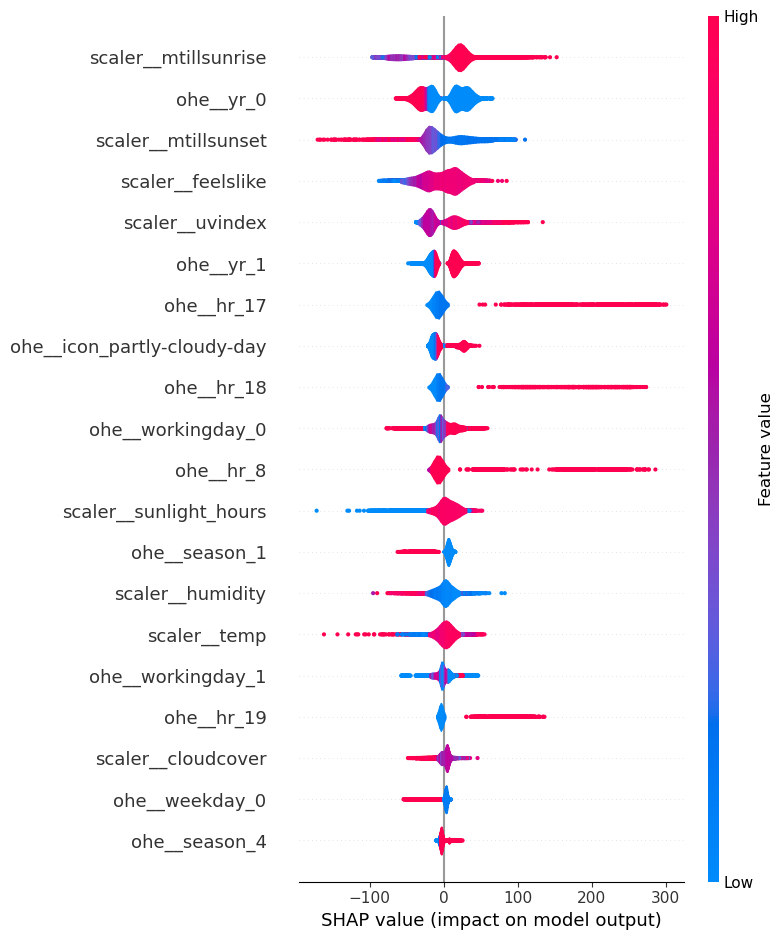

In [880]:
shap.summary_plot(shap_values, X_Final, plot_type="violin")

In [881]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 15:39].values,
    features=X_Final.iloc[:, 15:39],
    plot_type="violin")

In [882]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 41:48].values,
    features=X_Final.iloc[:, 41:48],
    plot_type="violin")

In [883]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 50:54].values,
    features=X_Final.iloc[:, 50:54],
    plot_type="violin")

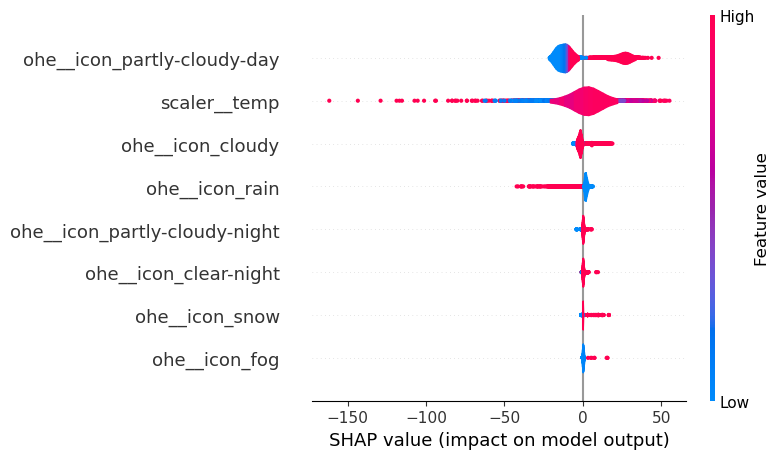

In [884]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 55:63].values,
    features=X_Final.iloc[:, 55:63],
    plot_type="violin")

In [885]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 70:74].values,
    features=X_Final.iloc[:, 70:74],
    plot_type="violin")

In [886]:
shap.summary_plot(
    shap_values=shap_values_df.iloc[:, 63:70].values,
    features=X_Final.iloc[:, 63:70],
    plot_type="violin")

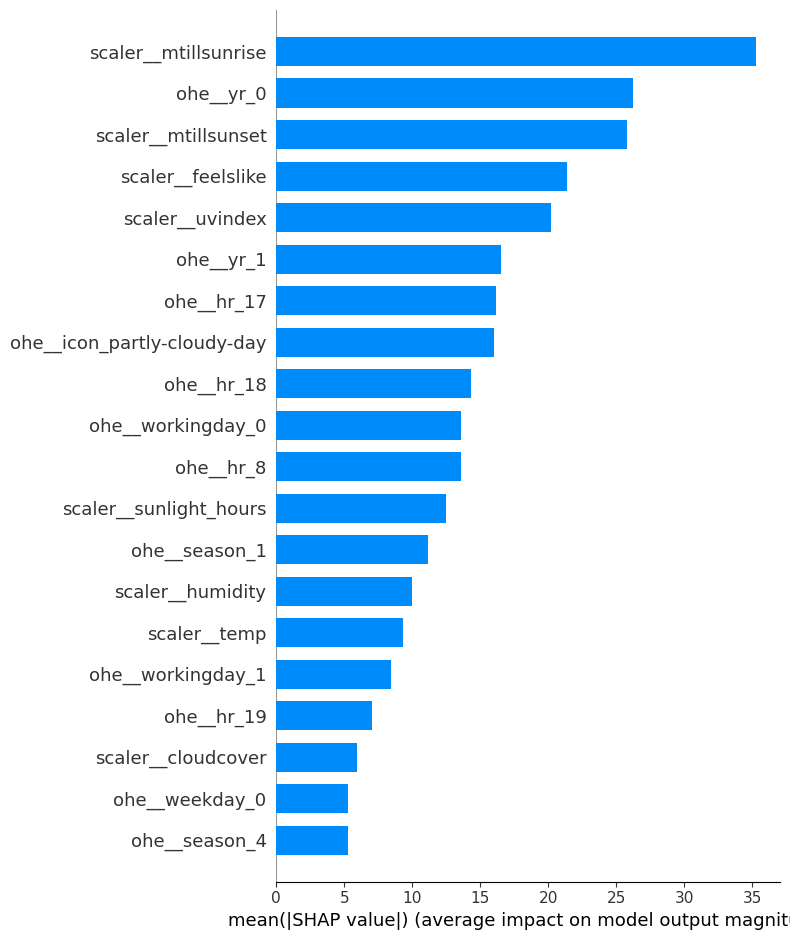

In [887]:
shap.summary_plot(
    shap_values=shap_values_df.values,
    features=X_Final,
    plot_type="bar")

## PART III: Streamlit dashboard

In [5]:
### This part goes in a separate script ###